In [1]:
# Colab cell
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Adjust these two for YOUR repo
REPO_OWNER = "ywanglab"
REPO_NAME  = "STAT4160"   # e.g., unified-stocks-team1

BASE_DIR   = "/content/drive/MyDrive/dspt25"
CLONE_DIR  = f"{BASE_DIR}/{REPO_NAME}"
REPO_URL   = f"https://github.com/{REPO_OWNER}/{REPO_NAME}.git"

import os, pathlib
pathlib.Path(BASE_DIR).mkdir(parents=True, exist_ok=True)


In [3]:
import os, subprocess, shutil, pathlib

if not pathlib.Path(CLONE_DIR).exists():
    !git clone {REPO_URL} {CLONE_DIR}
else:
    # If the folder exists, just ensure it's a git repo and pull latest
    os.chdir(CLONE_DIR)
    # !git status
    # !git pull --rebase # !git pull --ff-only
os.chdir(CLONE_DIR)
print("Working dir:", os.getcwd())

Working dir: /content/drive/MyDrive/dspt25/STAT4160


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pathlib import Path
from datetime import datetime

#| tags: [parameters]
# Default values (overridden by -P at render time)
symbol = "AAPL"
start_date = "2018-01-01"
end_date = ""          # empty means "open ended"
rolling = 20
# Read parameters
# SYMBOL = params.get("symbol", "AAPL")
# START  = params.get("start_date", "2018-01-01")
# END    = params.get("end_date", "")
# ROLL   = int(params.get("rolling", 20))
SYMBOL = "AAPL"
START  = "2018-01-01"
END    = ""
ROLL   =  20

if not END:
    END = pd.Timestamp.today().strftime("%Y-%m-%d")

SYMBOL, START, END, ROLL

('AAPL', '2018-01-01', '2025-08-22', 20)

In [5]:
# Fetch adjusted OHLCV
try:
    data = yf.download(SYMBOL, start=START, end=END, auto_adjust=True, progress=False)
except Exception as e:
    print("yfinance failed, falling back to synthetic series:", e)
    idx = pd.bdate_range(START, END)
    rng = np.random.default_rng(42)
    ret = rng.normal(0, 0.01, len(idx))
    price = 100 * np.exp(np.cumsum(ret))
    vol = rng.integers(1e5, 5e6, len(idx))
    data = pd.DataFrame({"Close": price, "Volume": vol}, index=idx)

# Tidy & features
df = data.rename(columns=str.lower).copy()
df = df[["close","volume"]].dropna()
df["log_return"] = np.log(df["close"]).diff()
df["roll_mean"]  = df["log_return"].rolling(ROLL, min_periods=ROLL//2).mean()
df["roll_vol"]   = df["log_return"].rolling(ROLL, min_periods=ROLL//2).std()
df = df.dropna()
df.head()

Price,close,volume,log_return,roll_mean,roll_vol
Ticker,aapl,aapl,,,
Date,,,,,
2018-01-17,41.984413,137547200,0.016381,0.003894,0.007023
2018-01-18,42.021935,124773600,0.000893,0.003621,0.006724
2018-01-19,41.834400,129700400,-0.004473,0.002947,0.006823
2018-01-22,41.492134,108434400,-0.008215,0.002088,0.007229
2018-01-23,41.501522,130756400,0.000226,0.001955,0.006963


In [6]:
# Add to the "Tidy & features" section in eda.qmd
df["cum_return"] = df["log_return"].cumsum().fillna(0.0)
peak = df["cum_return"].cummax()
df["drawdown"] = df["cum_return"] - peak

# Regime via rolling volatility terciles
vol = df["log_return"].rolling(ROLL, min_periods=ROLL//2).std()
q1, q2 = vol.quantile([0.33, 0.66])
def regime(v):
    if np.isnan(v): return "mid"
    return "low" if v < q1 else ("high" if v > q2 else "mid")
df["regime"] = [regime(v) for v in vol]
df["regime"].value_counts().to_frame("days").T

regime,high,mid,low
days,646,637,627


PosixPath('reports/figs/AAPL_drawdown.png')

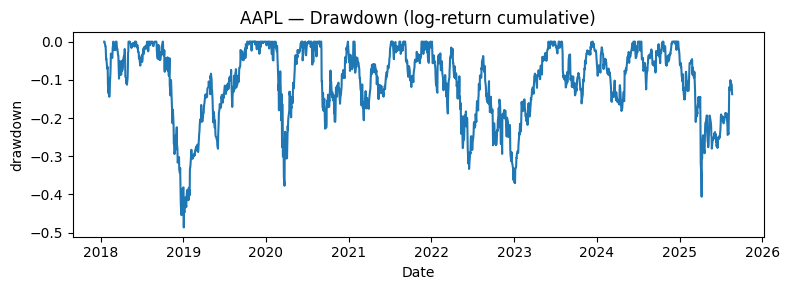

In [7]:
# Drawdown plot
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index, df["drawdown"])
ax.set_title(f"{SYMBOL} — Drawdown (log-return cumulative)")
ax.set_xlabel("Date"); ax.set_ylabel("drawdown")
fig.tight_layout()
figpath = Path("reports/figs")/f"{SYMBOL}_drawdown.png"
fig.savefig(figpath, dpi=144)
figpath

PosixPath('reports/figs/AAPL_price_regimes.png')

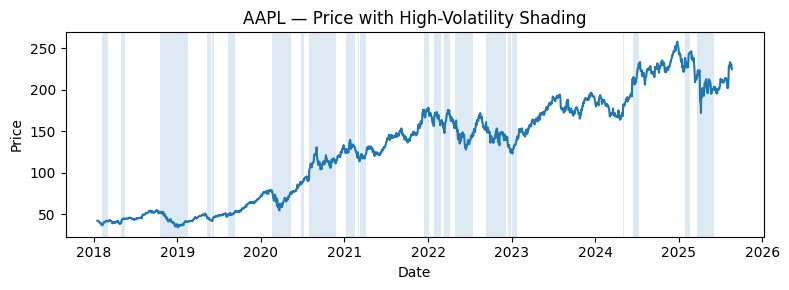

In [8]:
# Price with regime shading (simple)
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index, df["close"])
ax.set_title(f"{SYMBOL} — Price with High-Volatility Shading")
ax.set_xlabel("Date"); ax.set_ylabel("Price")

# Shade where regime == 'high'
mask = (df["regime"] == "high")
# merge contiguous regions
in_region = False
start = None
for i, (ts, is_high) in enumerate(zip(df.index, mask)):
    if is_high and not in_region:
        in_region = True
        start = ts
    if in_region and (not is_high or i == len(df)-1):
        end = df.index[i-1] if not is_high else ts
        ax.axvspan(start, end, alpha=0.15)  # shaded band
        in_region = False
fig.tight_layout()
figpath = Path("reports/figs")/f"{SYMBOL}_price_regimes.png"
fig.savefig(figpath, dpi=144)
figpath

PosixPath('reports/figs/AAPL_price.png')

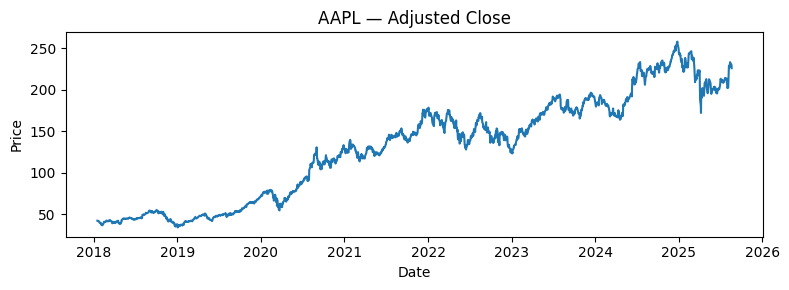

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index, df["close"])
ax.set_title(f"{SYMBOL} — Adjusted Close")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
fig.tight_layout()
figpath = Path("reports/figs")/f"{SYMBOL}_price.png"
fig.savefig(figpath, dpi=144)
figpath

PosixPath('reports/figs/AAPL_hist.png')

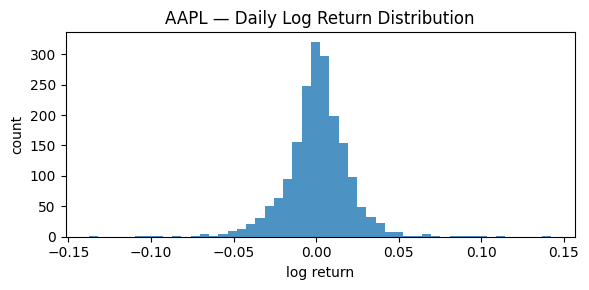

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(df["log_return"], bins=50, alpha=0.8)
ax.set_title(f"{SYMBOL} — Daily Log Return Distribution")
ax.set_xlabel("log return"); ax.set_ylabel("count")
fig.tight_layout()
figpath = Path("reports/figs")/f"{SYMBOL}_hist.png"
fig.savefig(figpath, dpi=144)
figpath

PosixPath('reports/figs/AAPL_rolling.png')

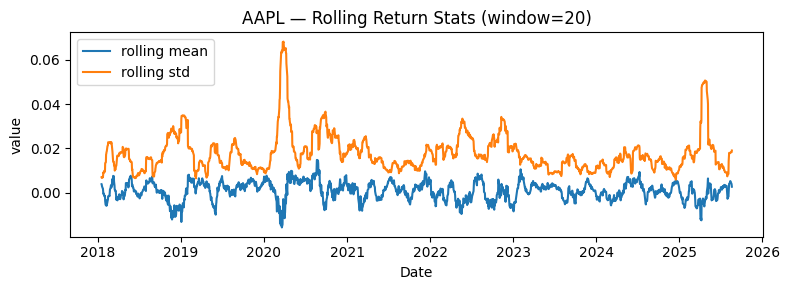

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index, df["roll_mean"], label="rolling mean")
ax.plot(df.index, df["roll_vol"],  label="rolling std")
ax.set_title(f"{SYMBOL} — Rolling Return Stats (window={ROLL})")
ax.set_xlabel("Date"); ax.set_ylabel("value")
ax.legend()
fig.tight_layout()
figpath = Path("reports/figs")/f"{SYMBOL}_rolling.png"
fig.savefig(figpath, dpi=144)
figpath

In [ ]:
summary = pd.DataFrame({
    "n_days": [len(df)],
    "start": [df.index.min().date()],
    "end":   [df.index.max().date()],
    "mean_daily_ret": [df["log_return"].mean()],
    "std_daily_ret":  [df["log_return"].std()],
    "ann_vol_approx": [df["log_return"].std()*np.sqrt(252)]
})
summary

,n_days,start,end,mean_daily_ret,std_daily_ret,ann_vol_approx
0,1909,2018-01-17,2025-08-20,0.00089,0.019685,0.312487
